In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
from skimage import transform
#import torch
#import torch.nn as nn
#from torch.utils.data import Dataset, DataLoader
#import torch.multiprocessing as mp
#import monai
import sys
sys.path.append('../../../modified_medsam_repo')
import argparse
import random
from datetime import datetime
import shutil
import glob
import pandas as pd
import nibabel as nib
import pickle
import time
from PIL import Image

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.loss_funcs_hcp import *

In [3]:
# https://stackoverflow.com/questions/19349410/how-to-pad-with-zeros-a-tensor-along-some-axis-python
def symmetric_pad_array(input_array: np.ndarray, target_shape: tuple, pad_value: int) -> np.ndarray:

    for dim_in, dim_target in zip(input_array.shape, target_shape):
        if dim_target < dim_in:
            raise Exception("`target_shape` should be greater or equal than `input_array` shape for each axis.")

    pad_width = []
    for dim_in, dim_target  in zip(input_array.shape, target_shape):
        if (dim_in-dim_target)%2 == 0:
            pad_width.append((int(abs((dim_in-dim_target)/2)), int(abs((dim_in-dim_target)/2))))
        else:
            pad_width.append((int(abs((dim_in-dim_target)/2)), (int(abs((dim_in-dim_target)/2))+1)))
    
    return np.pad(input_array, pad_width, 'constant', constant_values=pad_value)

In [14]:
#path = glob.glob('/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/BraTS20_Training_*/*_t1.nii.gz')[8]
path = '/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii.gz'
data_brats_mri = nib.load(path)
data = data_brats_mri.get_fdata()
data = (data / data.max() * 200).astype('uint8')

print(data.shape)
print(data.min())
print(data.max())


(240, 240, 155)
0
200


In [13]:
#path_hcp = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/126628/mri/T1.mgz'
path_hcp = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/126628/mri/brainmask.mgz'

data_hcp_mri = nib.load(path_hcp)
data_hcp = data_hcp_mri.get_fdata()

print(data_hcp.shape)
print(data_hcp.min())
print(data_hcp.max())

(256, 256, 256)
0.0
194.0


/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[ -1.   0.   0.   0.]
 [  0.   0.   1.   0.]
 [  0.  -1.   0. 147.]
 [  0.   0.   0.   1.]]


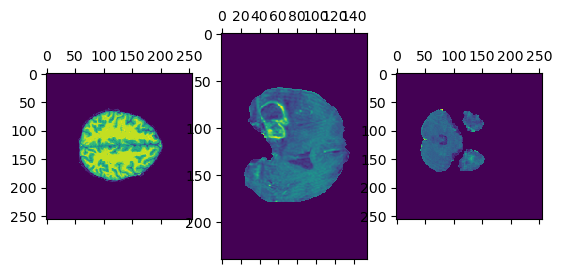

In [15]:
from nibabel.processing import resample_from_to
from dipy.align.transforms import AffineTransform3D
from dipy.align.imaffine import AffineRegistration

corrected_affine = data_hcp_mri.affine.copy()
corrected_affine[:,3] += np.array([-127,145.5, 0,0])
print(corrected_affine)
img_res = resample_from_to(data_brats_mri, (data_hcp_mri.shape, corrected_affine))

tt = img_res.get_fdata()

fig, ax = plt.subplots(1, 3)
sli = 110
ax[0].matshow(data_hcp_mri.get_fdata()[:,sli,:])
ax[1].matshow(data_brats_mri.get_fdata()[:,sli,:])
ax[2].matshow(img_res.get_fdata()[:,sli,:])

# first dim is matched

In [16]:
affreg = AffineRegistration()
affine3d = affreg.optimize(data_hcp_mri.get_fdata(), img_res.get_fdata(), AffineTransform3D(), params0=None)
xform = affine3d.transform(img_res.get_fdata())

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


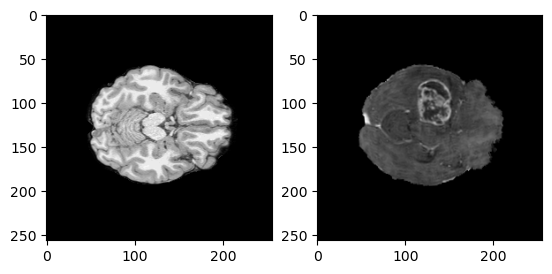

In [23]:
fig, axs = plt.subplots(1,2)
sli = 160
#zz = data_brats_mri.get_fdata()[:,:,sli]
zz = xform[:,sli,:]
xx = data_hcp_mri.get_fdata()[:,sli,:]
axs[0].imshow(np.repeat(xx[:,:,None], 3, axis = 2) / np.max(xx))
axs[1].imshow(np.repeat(zz[:,:,None], 3, axis = 2) / np.max(zz))

In [9]:
# make it into nibabel now
to_save = nib.Nifti1Image(xform, affine=data_hcp_mri.affine)
nib.save(to_save, '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_hcp_experiment_10-26-24/registered_t1.nii')

In [18]:
xy = nib.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/registered_hcp_experiment_10-26-24/inputs/brats_001_registered/registered_t1.nii').get_fdata()
zy = xy[:,128,:]
plt.imshow(np.repeat(zy[:,:,None], 3, axis=2) / zy.max())

553.7801498940798


In [225]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

metric = CCMetric(3, sigma_diff=20, radius=20)
sdr = SymmetricDiffeomorphicRegistration(metric)

mapping = sdr.optimize(data_hcp_mri.get_fdata(), xform, prealign=affine3d.affine)
warped = mapping.transform(xform)

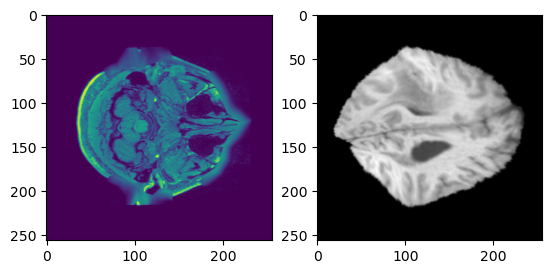

In [234]:
fig, axs = plt.subplots(1,2)
sli = 200
#zz = data_brats_mri.get_fdata()[:,:,sli]
zz = warped[:,sli,:]
axs[0].imshow(data_hcp_mri.get_fdata()[:,sli,:])
axs[1].imshow(np.repeat(zz[:,:,None], 3, axis = 2) / np.max(zz))

In [123]:
print(data_brats_mri.affine)
print(data_hcp_mri.affine)

[[ -1.   0.   0.  -0.]
 [  0.  -1.   0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
[[  -1.     0.     0.   127. ]
 [   0.     0.     1.  -145.5]
 [   0.    -1.     0.   147. ]
 [   0.     0.     0.     1. ]]


In [31]:
path_seg = '/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii.gz'
np.unique(nib.load(path_seg).get_fdata())

array([0., 1., 2., 4.])

In [23]:
def preprocess_file(path):
    data = nib.load(path).get_fdata()
    print(f'max is {data.max()}')
    print(f'min is {data.min()}')
    data = (data / data.max() * 255).astype('uint8')

    data = np.transpose(data, (0,2,1))
    data = np.flip(data, axis=2)
    data = np.flip(data, axis=1)
    data = symmetric_pad_array(data, (256,256,256), 0)

    return data


max is 13997.0
min is 0.0
max is 4.0
min is 0.0


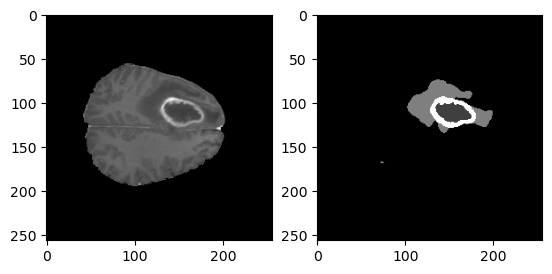

In [27]:

data = preprocess_file('/gpfs/data/luilab/karthik/brats_dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_t1.nii.gz')
seg_data = preprocess_file('/gpfs/data/luilab/karthik/brats_dataset/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii.gz')

#path = '/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mri/T1.mgz'
#data_hcp = nib.load(path).get_fdata()
#data_hcp = (data_hcp / data_hcp.max() * 255).astype('uint8')

idx = 100
slice_data = data[:,idx,:]
seg_slice = seg_data[:,idx,:]
slice_data = np.repeat(slice_data[:,:,None], 3, axis = -1)
seg_slice = np.repeat(seg_slice[:,:,None], 3, axis = -1)


fig, ax = plt.subplots(1,2)

ax[0].imshow(slice_data)
ax[1].imshow(seg_slice)

219


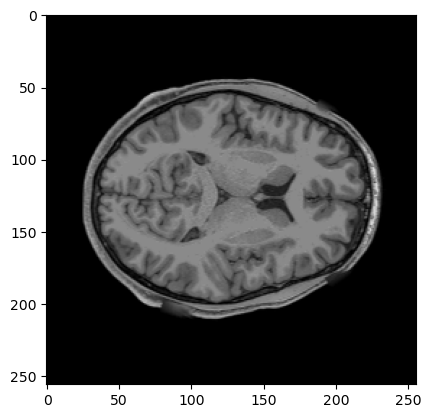

In [4]:
slice_data_hcp = data_hcp[:,140,:]
#slice_data = slice_data.astype('int')
print(slice_data_hcp.max())
slice_data_hcp = np.repeat(slice_data_hcp[:,:,None], 3, axis=-1)

plt.imshow(slice_data_hcp)

245


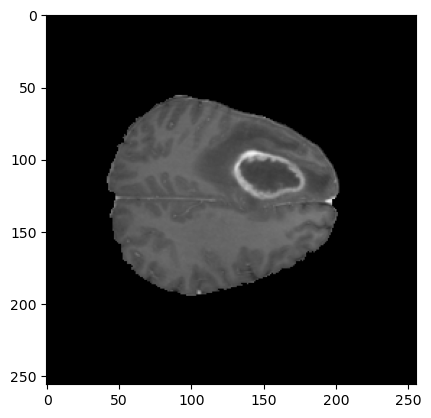

In [32]:
slice_data = data[:,100,:]



#slice_data = slice_data.astype('int')
print(slice_data.max())
slice_data = np.repeat(slice_data[:,:,None], 3, axis=-1)

plt.imshow(slice_data)



In [10]:
slice_data.shape
im = Image.fromarray(slice_data)
im.save('')

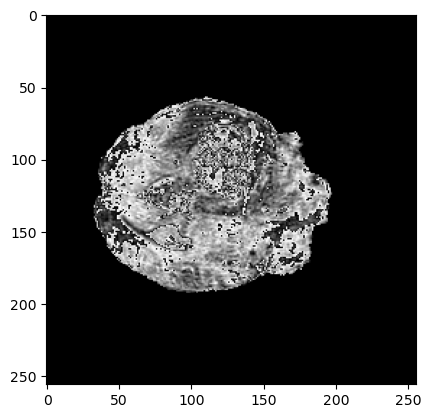

In [14]:
xx = Image.open('/gpfs/data/luilab/karthik/pediatric_seg_proj/brats_slices_npy/dir_structure_for_yolov7/train/images/001_slice140.png')
plt.imshow(xx)

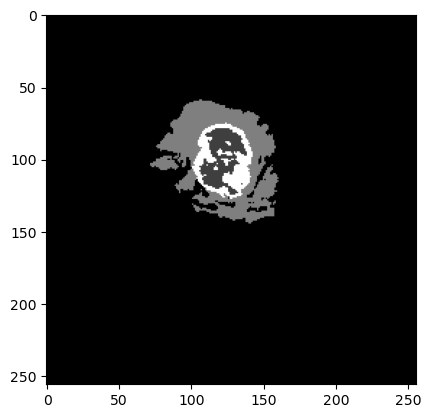

In [9]:
xx = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/brats_slices_npy/segmentation_slices/001/seg_140.npy')
xx = np.repeat(xx[:,:,None], 3, axis=-1)

plt.imshow(xx / xx.max())